# Multi-class Classification with CNNs: cifar-10

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets

import datetime

notebook_start_time = datetime.datetime.now()
print(f"Notebook last run (end-to-end): {notebook_start_time}")

2025-04-25 14:12:22.946537: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-25 14:12:23.118709: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745604743.208657   12216 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745604743.224746   12216 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745604743.369699   12216 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Notebook last run (end-to-end): 2025-04-25 14:12:26.449059


In [3]:
cifar_10 = datasets.cifar10.load_data()
(X_train, y_train), (X_test, y_test) = cifar_10
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
print(f"{X_train.shape = }\n{y_train.shape = }\n{X_test.shape = }\n{y_test.shape = }")

X_train.shape = (50000, 32, 32, 3)
y_train.shape = (50000, 1)
X_test.shape = (10000, 32, 32, 3)
y_test.shape = (10000, 1)


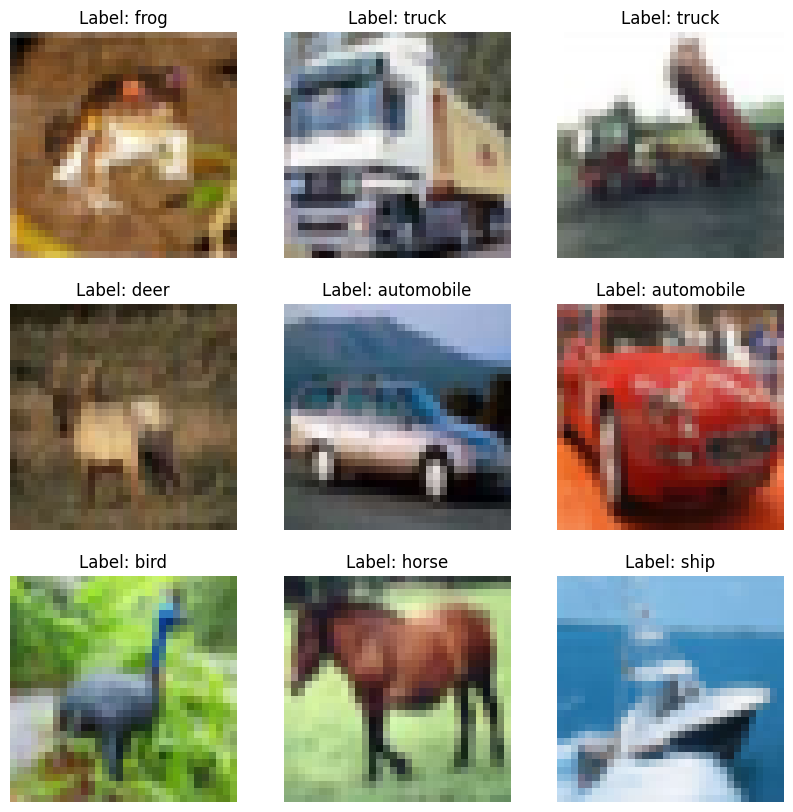

In [3]:
# Display a few images from the dataset
def display_images(images, labels):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {classes[labels[i][0]]}")
        plt.axis("off")
    plt.show()
display_images(X_train[:9], y_train[:9])

In [4]:
def get_class_training_weights(train_ds, normalize = True):
    labels, counts = np.unique(np.concatenate([y for x, y in train_ds], axis=0), return_counts=True)
    total = sum(counts)

    weights = [total/(2*count) for count in counts]
    max_weight = np.max(weights)

    if normalize:
        return {l : weights[i]/max_weight for i, l in enumerate(labels)}

    return {l : weights[i] for i, l in enumerate(labels)}

class_weight = get_class_training_weights(train_ds=cifar_10)
for class_id, weight in class_weight.items():
    print(f"Class {classes[int(class_id)]}: {weight:.2f}")

Class airplane: 1.00
Class automobile: 1.00
Class bird: 1.00
Class cat: 1.00
Class deer: 1.00
Class dog: 1.00
Class frog: 1.00
Class horse: 1.00
Class ship: 1.00
Class truck: 1.00


In [ ]:
model_count = 1
epochs = 20

In [ ]:
from dataclasses import dataclass

class ModelBuilder:

    _input_shape = (32, 32, 3)
    _optimizer: tf.keras.Optimizer = None
    _layers_augmentation: list[tf.keras.Layer] = []
    _learning_rate: float = 1e-4
    _loss: tf.keras.Loss = None
    _metrics: list[tf.keras.Metric] = None
    _classes = 10

    def build(self, core_layers: list[tf.keras.Layer], name = "") -> (tf.keras.models.Sequential, tf.keras.models.Sequential):
        if self._optimizer is None:
            self._optimizer = tf.keras.optimizers.AdamW(learning_rate=self._learning_rate)

        if self._loss is None:
            if self._classes == 2:
                self._loss = tf.keras.losses.BinaryCrossentropy()
            else:
                self._loss = tf.keras.losses.SparseCategoricalCrossentropy()

        if self._metrics is None:
            self._metrics = [
                #tf.keras.metrics.TruePositives(name='tp'),
                #tf.keras.metrics.TrueNegatives(name='tn'),
                #tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                tf.keras.metrics.SparseCategoricalAccuracy(name='sparse_accuracy'),
            ]

        model = tf.keras.models.Sequential(name=name)

        model.add(tf.keras.layers.InputLayer(self._input_shape, name="input"))

        for layer in self._layers_augmentation:
            model.add(layer)

        model.add(tf.keras.layers.Rescaling(1./255, name="rescale"))
        for layer in core_layers:
            model.add(layer)
        if self._classes == 2:
            output = tf.keras.layers.Dense(1, activation="sigmoid", name="output")
        else:
            output = tf.keras.layers.Dense(self._classes, activation="softmax", name="output")
        model.add(output)
        model.compile(
            optimizer=self._optimizer,
            loss=self._loss,
            metrics=self._metrics
        )
        return model_train, model_test

    def loss(self, loss):
        """Loss function"""
        self._loss = loss
        return self

    def metrics(self, metrics):
        self._metrics = metrics
        return self

    def optimizer(self, optimizer):
        self._optimizer = optimizer
        return self

    def learning_rate(self, learning_rate):
        if self._optimizer is not None:
            raise Exception("Learning rate was specified after optimizer. Specify only the optimizer or only the learning rate")
        self._learning_rate = learning_rate
        return self

    def augmentation(self, layers: list[tf.keras.Layer] = None):
        if layers is None or not layers:
            layers = [
                tf.keras.layers.RandomFlip("horizontal", name="0.1rflip"),
                tf.keras.layers.RandomRotation(0.2, name="0.2rrot"),
                tf.keras.layers.RandomBrightness(0.2, name="0.3rbright"),
                tf.keras.layers.RandomContrast(0.2, name="0.4rcont"),
            ]
        self._layers_augmentation = layers
        return self

## Training

In [8]:
# first attempt with just a dense neural net
model1 = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, name="rescale"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model1.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
history1 = model1.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    steps_per_epoch=steps_per_epoch,
)

Epoch 1/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.1104 - loss: 6.9685 - val_accuracy: 0.1656 - val_loss: 2.3209
Epoch 2/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.1371 - loss: 2.2819 - val_accuracy: 0.2411 - val_loss: 2.1302
Epoch 3/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - accuracy: 0.2178 - loss: 2.1006 - val_accuracy: 0.2500 - val_loss: 2.0361
Epoch 4/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - accuracy: 0.2490 - loss: 2.0205 - val_accuracy: 0.2791 - val_loss: 1.9997
Epoch 5/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - accuracy: 0.2635 - loss: 1.9908 - val_accuracy: 0.3017 - val_loss: 1.9465
Epoch 6/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step - accuracy: 0.3075 - loss: 1.9317 - val_accuracy: 0.3183 - val_loss: 1.8778
Epoch 7/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step - accuracy: 0.3112 - loss: 1.8872 - val_accuracy: 0.3310 - val_loss: 1.8684
Epoch 8/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step - accuracy: 0.3003 - loss: 1.9017 - val_accuracy: 0.

In [ ]:
core_layers = [
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(64, activation='relu'),
]

model_train, model_test = ModelBuilder().build(core_layers, name=f"Model_{model_count}")

history = model_train.fit(
    X_train,
    y_train,
    epochs=epochs,
)

Epoch 1/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 56s 35ms/step - loss: 1.9669 - sparse_accuracy: 0.2944
Epoch 2/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - loss: 1.4975 - sparse_accuracy: 0.4721
Epoch 3/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 51s 32ms/step - loss: 1.3593 - sparse_accuracy: 0.5248
Epoch 4/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - loss: 1.2598 - sparse_accuracy: 0.5581
Epoch 5/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - loss: 1.1959 - sparse_accuracy: 0.5791
Epoch 6/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - loss: 1.1421 - sparse_accuracy: 0.6025
Epoch 7/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 45s 29ms/step - loss: 1.0919 - sparse_accuracy: 0.6228
Epoch 8/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 39s 25ms/step - loss: 1.0516 - sparse_accuracy: 0.6360
Epoch 9/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 36s 23ms/step - loss: 1.0228 - sparse_accuracy: 0.6446
Epoch 10/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 39s 25ms/step - loss: 0.9812 - sparse_accuracy: 0.6622
Epoch 11/25
1563/1563 ━━━━━━━

In [13]:
model_test.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3.8109 - sparse_accuracy: 0.6895


[3.80729603767395, 0.6369333267211914]

In [14]:
model_count += 1
core_layers = [
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
]

model_train, model_test = ModelBuilder().build(core_layers, name=f"Model_{model_count}")

history = model_train.fit(
    X_train,
    y_train,
    epochs=epochs,
)

Epoch 1/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 146s 93ms/step - loss: 1.8710 - sparse_accuracy: 0.3209
Epoch 2/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 146s 94ms/step - loss: 1.3668 - sparse_accuracy: 0.5069
Epoch 3/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 141s 91ms/step - loss: 1.2182 - sparse_accuracy: 0.5664
Epoch 4/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 148s 95ms/step - loss: 1.0871 - sparse_accuracy: 0.6132
Epoch 5/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 145s 92ms/step - loss: 1.0009 - sparse_accuracy: 0.6485
Epoch 6/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 144s 92ms/step - loss: 0.9273 - sparse_accuracy: 0.6723
Epoch 7/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 146s 93ms/step - loss: 0.8528 - sparse_accuracy: 0.7046
Epoch 8/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 141s 90ms/step - loss: 0.8069 - sparse_accuracy: 0.7216
Epoch 9/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 146s 93ms/step - loss: 0.7650 - sparse_accuracy: 0.7341
Epoch 10/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 145s 92ms/step - loss: 0.7190 - sparse_accuracy: 0.7520
Epoch 11/25
1563/15

In [15]:
model_test.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 5.8759 - sparse_accuracy: 0.8606


[5.887906074523926, 0.7978833317756653]

In [11]:
def plot_confusion_matrix(y_true, X_test, model_test, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    y_pred = np.argmax(model_test.predict(X_test), axis=1)
    cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=len(classes))
    cm = cm.numpy()
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    threshold = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step


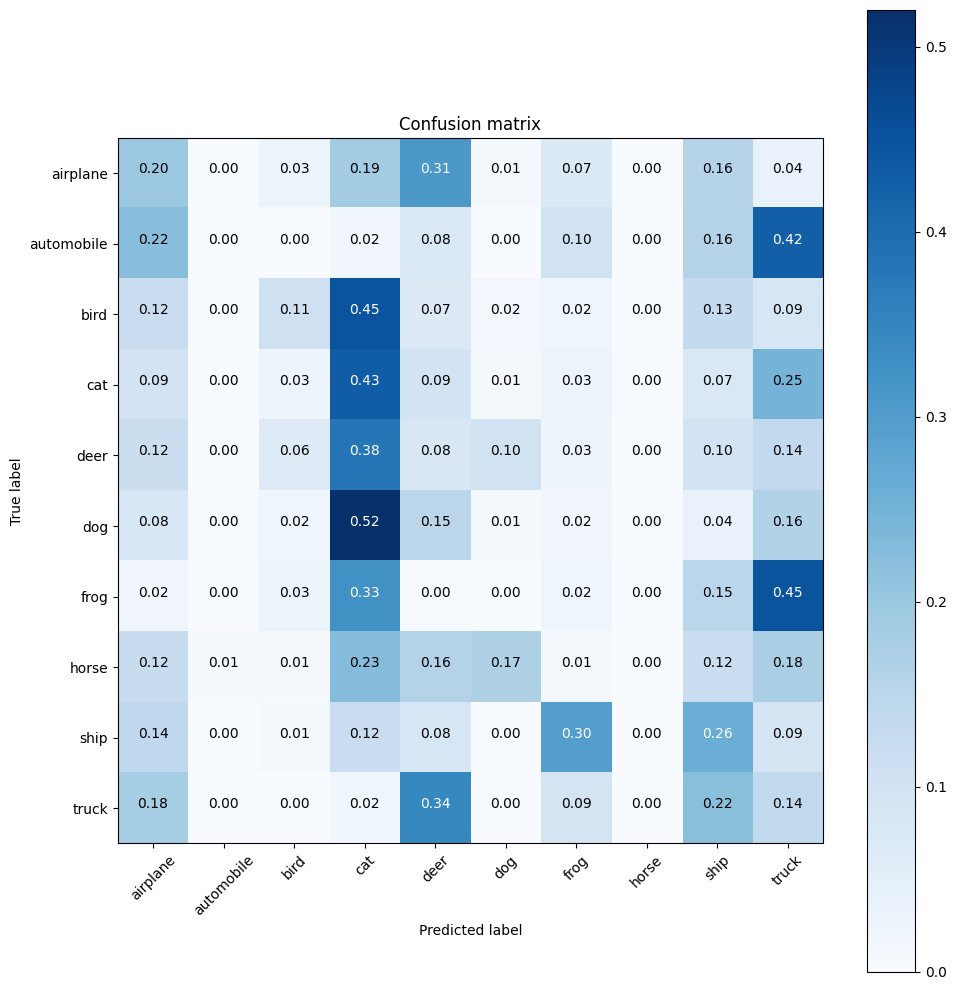

In [20]:
y_pred = model_test.predict(X_test)
plot_confusion_matrix(y_test, y_pred, classes, title='Confusion matrix')

In [ ]:
model_count += 1
core_layers = [
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
]

model_train, model_test = ModelBuilder().build(core_layers, name=f"Model_{model_count}")

history = model_train.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data=(X_test, y_test),
)

Epoch 1/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 128s 80ms/step - loss: 2.2425 - sparse_accuracy: 0.1279 - val_loss: 1.9102 - val_sparse_accuracy: 0.2744
Epoch 2/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 121s 78ms/step - loss: 1.9074 - sparse_accuracy: 0.2604 - val_loss: 1.8165 - val_sparse_accuracy: 0.2940
Epoch 3/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 125s 80ms/step - loss: 1.7988 - sparse_accuracy: 0.3016 - val_loss: 1.7328 - val_sparse_accuracy: 0.3496
Epoch 4/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 124s 80ms/step - loss: 1.6762 - sparse_accuracy: 0.3669 - val_loss: 1.5645 - val_sparse_accuracy: 0.4160
Epoch 5/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 124s 79ms/step - loss: 1.5940 - sparse_accuracy: 0.4040 - val_loss: 1.5060 - val_sparse_accuracy: 0.4350
Epoch 6/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 127s 81ms/step - loss: 1.5313 - sparse_accuracy: 0.4287 - val_loss: 1.4698 - val_sparse_accuracy: 0.4534
Epoch 7/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 114s 73ms/step - loss: 1.4902 - sparse_accuracy: 0.4455 - val_loss: 1.4521 -

In [ ]:
model_test.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 2.6660 - sparse_accuracy: 0.4972


[2.672578811645508, 0.39980000257492065]

In [23]:
model_count += 1
core_layers = [
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
]

model_train, model_test = ModelBuilder().build(core_layers, name=f"Model_{model_count}")

history = model_train.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data=(X_test, y_test),
)

Epoch 1/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 125s 79ms/step - loss: 2.0547 - sparse_accuracy: 0.2314 - val_loss: 1.6259 - val_sparse_accuracy: 0.4030
Epoch 2/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 107s 69ms/step - loss: 1.5912 - sparse_accuracy: 0.4130 - val_loss: 1.5256 - val_sparse_accuracy: 0.4362
Epoch 3/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 89s 57ms/step - loss: 1.4756 - sparse_accuracy: 0.4610 - val_loss: 1.3926 - val_sparse_accuracy: 0.4979
Epoch 4/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 88s 57ms/step - loss: 1.3763 - sparse_accuracy: 0.5040 - val_loss: 1.3173 - val_sparse_accuracy: 0.5175
Epoch 5/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 89s 57ms/step - loss: 1.2849 - sparse_accuracy: 0.5350 - val_loss: 1.2588 - val_sparse_accuracy: 0.5447
Epoch 6/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 88s 56ms/step - loss: 1.2129 - sparse_accuracy: 0.5648 - val_loss: 1.2087 - val_sparse_accuracy: 0.5758
Epoch 7/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 73s 47ms/step - loss: 1.1504 - sparse_accuracy: 0.5906 - val_loss: 1.1267 - val_

In [24]:
model_test.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 3.6543 - sparse_accuracy: 0.5300


[3.6385116577148438, 0.40904998779296875]

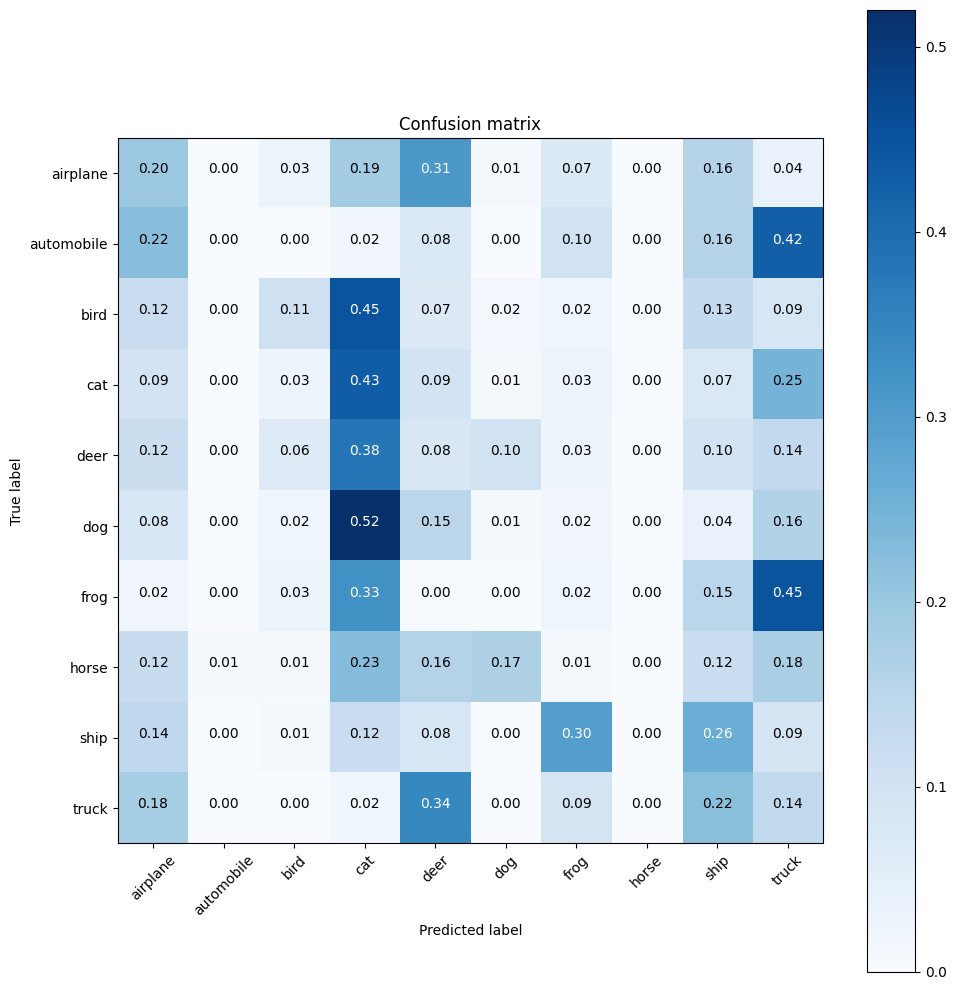

In [25]:
plot_confusion_matrix(y_test, y_pred, classes, title='Confusion matrix')

In [26]:
model_count += 1
epochs = 10
core_layers = [
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
]

model_train, model_test = ModelBuilder().build(core_layers, name=f"Model_{model_count}")

history = model_train.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data=(X_test, y_test),
)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 106s 67ms/step - loss: 1.8592 - sparse_accuracy: 0.3132 - val_loss: 1.3830 - val_sparse_accuracy: 0.4910
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 104s 66ms/step - loss: 1.3440 - sparse_accuracy: 0.5144 - val_loss: 1.1943 - val_sparse_accuracy: 0.5718
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 104s 67ms/step - loss: 1.1634 - sparse_accuracy: 0.5890 - val_loss: 1.0719 - val_sparse_accuracy: 0.6168
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 88s 56ms/step - loss: 1.0214 - sparse_accuracy: 0.6395 - val_loss: 0.9623 - val_sparse_accuracy: 0.6608
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 86s 55ms/step - loss: 0.9051 - sparse_accuracy: 0.6813 - val_loss: 0.9391 - val_sparse_accuracy: 0.6721
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 86s 55ms/step - loss: 0.8303 - sparse_accuracy: 0.7066 - val_loss: 0.8797 - val_sparse_accuracy: 0.6886
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 86s 55ms/step - loss: 0.7451 - sparse_accuracy: 0.7400 - val_loss: 0.8182 - val

In [27]:
model_test.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 3.0332 - sparse_accuracy: 0.5440


[3.0343756675720215, 0.43035000562667847]

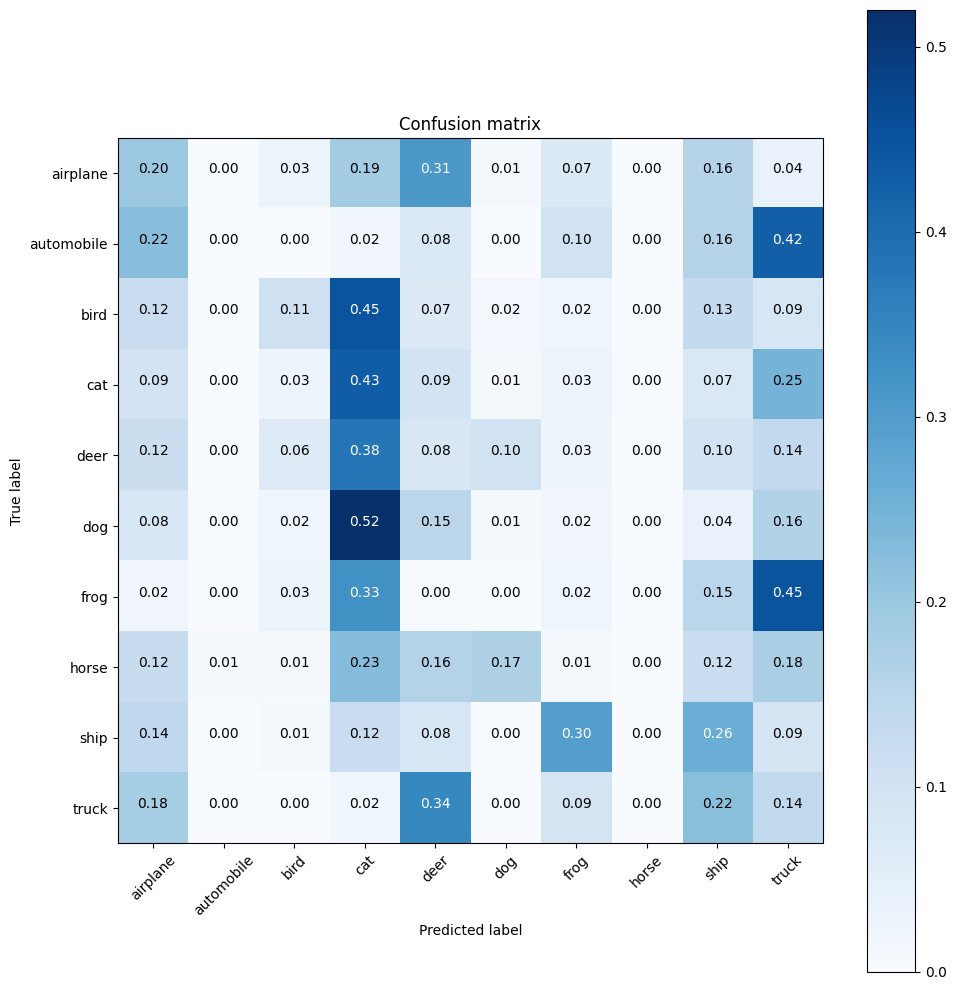

In [28]:
plot_confusion_matrix(y_test, y_pred, classes, title='Confusion matrix')

In [9]:
model_count += 1
epochs = 10
# let's train something similar to Xception
core_layers = [
    tf.keras.layers.Conv2D(32, (3,3), strides=(2, 2), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dropout(0.3),
]

model_train, model_test = ModelBuilder().build(core_layers, name=f"Model_{model_count}")

history = model_train.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data=(X_test, y_test),
)

2025-04-25 14:14:04.776816: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 67s 42ms/step - loss: 1.6903 - sparse_accuracy: 0.3906 - val_loss: 1.3240 - val_sparse_accuracy: 0.5304
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 65s 42ms/step - loss: 1.1388 - sparse_accuracy: 0.5938 - val_loss: 1.1264 - val_sparse_accuracy: 0.5998
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 65s 42ms/step - loss: 0.9400 - sparse_accuracy: 0.6678 - val_loss: 1.0766 - val_sparse_accuracy: 0.6208
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 66s 42ms/step - loss: 0.7795 - sparse_accuracy: 0.7291 - val_loss: 1.0581 - val_sparse_accuracy: 0.6269
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 65s 42ms/step - loss: 0.6419 - sparse_accuracy: 0.7767 - val_loss: 1.0486 - val_sparse_accuracy: 0.6498
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 56s 36ms/step - loss: 0.5194 - sparse_accuracy: 0.8211 - val_loss: 1.1034 - val_sparse_accuracy: 0.6392
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 75s 48ms/step - loss: 0.4126 - sparse_accuracy: 0.8593 - val_loss: 1.1926 - val_sp

In [13]:
model_test.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 3.9478 - sparse_accuracy: 0.1610


[3.9479527473449707, 0.1597999930381775]

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


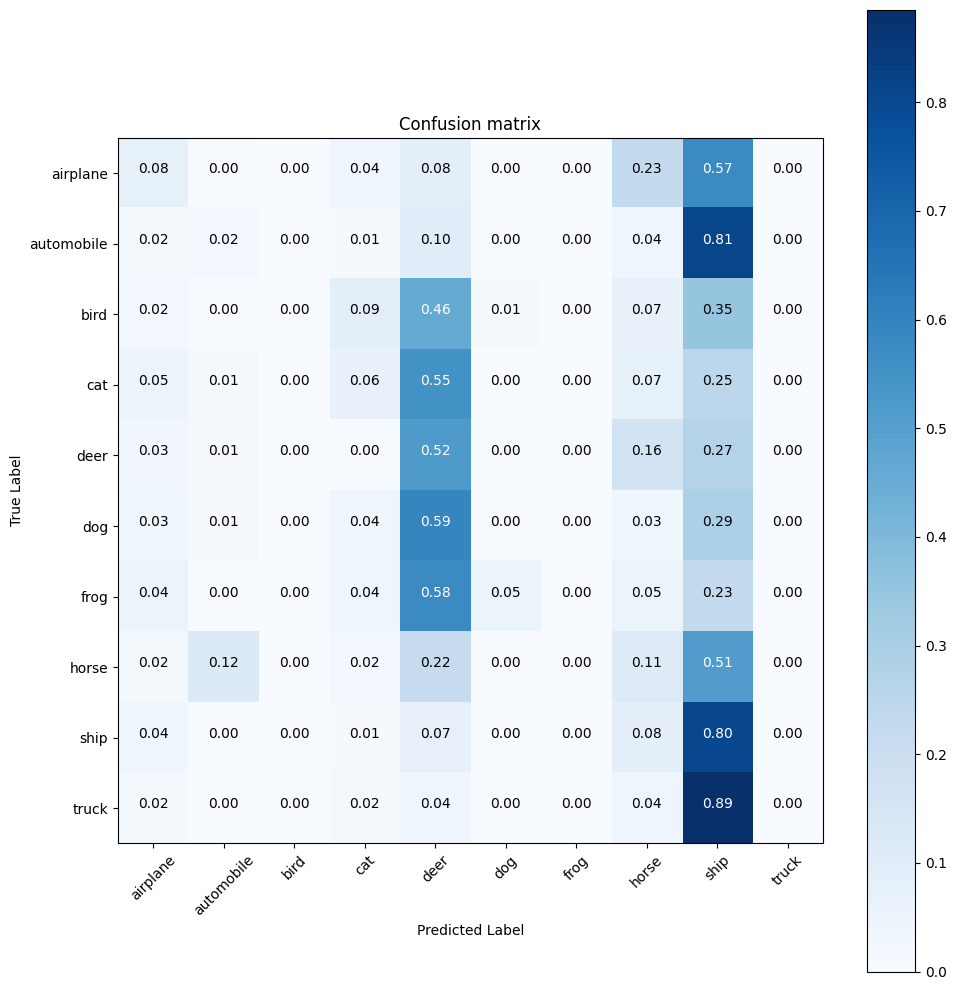

In [14]:
plot_confusion_matrix(y_test, X_test, model_test, classes, title='Confusion matrix')

In [15]:
model_count += 1
epochs = 10
# make even more similar to xception and add in dropout
core_layers = [
    tf.keras.layers.Conv2D(32, (3,3), strides=(2, 2), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.SeparableConv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.SeparableConv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
]

model_train, model_test = ModelBuilder().build(core_layers, name=f"Model_{model_count}")

history = model_train.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data=(X_test, y_test),
)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 51s 31ms/step - loss: 1.9430 - sparse_accuracy: 0.2700 - val_loss: 1.4924 - val_sparse_accuracy: 0.4624
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 54s 35ms/step - loss: 1.4708 - sparse_accuracy: 0.4672 - val_loss: 1.3001 - val_sparse_accuracy: 0.5218
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - loss: 1.3339 - sparse_accuracy: 0.5171 - val_loss: 1.2104 - val_sparse_accuracy: 0.5597
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 57s 37ms/step - loss: 1.2439 - sparse_accuracy: 0.5551 - val_loss: 1.1490 - val_sparse_accuracy: 0.5904
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - loss: 1.1702 - sparse_accuracy: 0.5821 - val_loss: 1.1323 - val_sparse_accuracy: 0.5951
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 49s 32ms/step - loss: 1.1057 - sparse_accuracy: 0.6091 - val_loss: 1.0814 - val_sparse_accuracy: 0.6165
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - loss: 1.0612 - sparse_accuracy: 0.6221 - val_loss: 1.0421 - val_sp

In [16]:
model_test.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.4837 - sparse_accuracy: 0.4654


[2.4774768352508545, 0.3549500107765198]

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


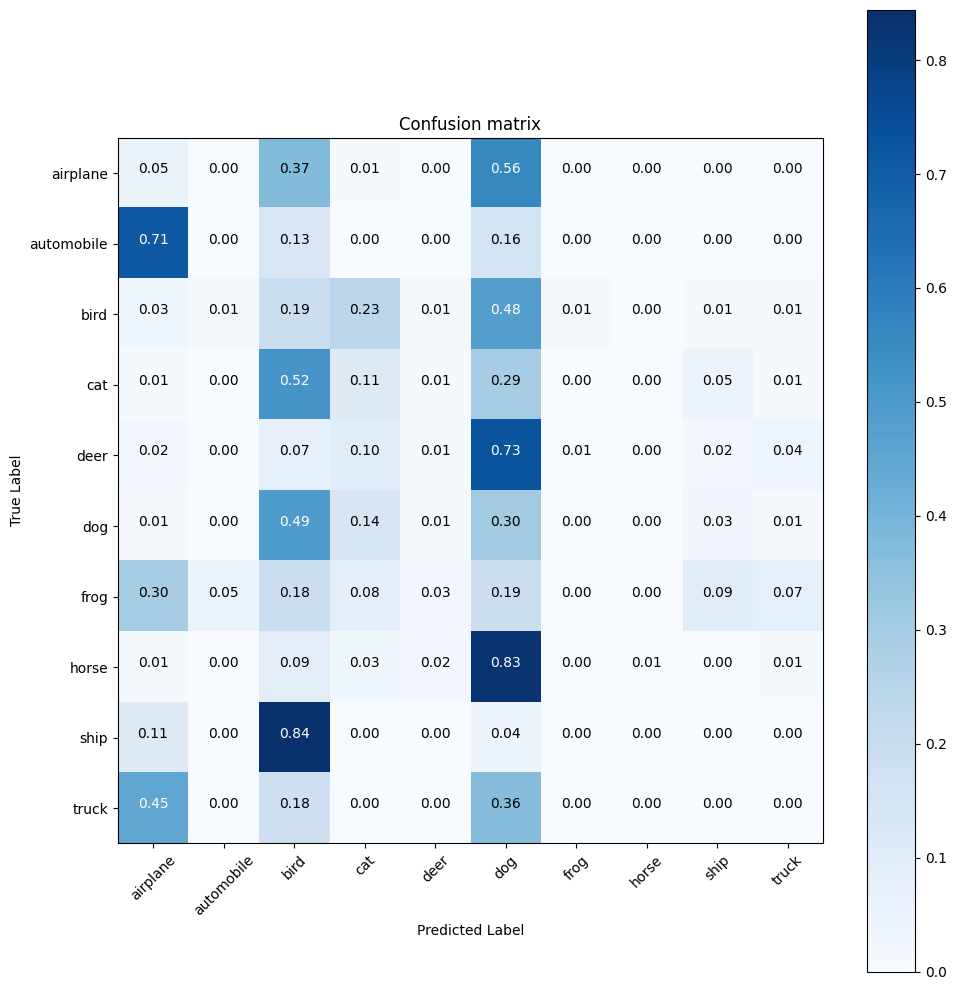

In [17]:
plot_confusion_matrix(y_test, X_test, model_test, classes, title='Confusion matrix')

In [19]:
model_count += 1
# go back to one of our earlier models and add in batch normalization
core_layers = [
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
]

model_train, model_test = ModelBuilder().build(core_layers, name=f"Model_{model_count}")

history = model_train.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data=(X_test, y_test),
)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - loss: 1.6024 - sparse_accuracy: 0.4327 - val_loss: 1.0996 - val_sparse_accuracy: 0.6100
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 140s 90ms/step - loss: 0.9487 - sparse_accuracy: 0.6675 - val_loss: 0.9539 - val_sparse_accuracy: 0.6680
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 135s 86ms/step - loss: 0.7270 - sparse_accuracy: 0.7487 - val_loss: 0.8943 - val_sparse_accuracy: 0.6889
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 104s 66ms/step - loss: 0.5551 - sparse_accuracy: 0.8114 - val_loss: 0.8457 - val_sparse_accuracy: 0.7068
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 119s 76ms/step - loss: 0.4050 - sparse_accuracy: 0.8658 - val_loss: 0.9016 - val_sparse_accuracy: 0.7007
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 96s 61ms/step - loss: 0.2830 - sparse_accuracy: 0.9101 - val_loss: 0.8897 - val_sparse_accuracy: 0.7208
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 97s 62ms/step - loss: 0.1810 - sparse_accuracy: 0.9490 - val_loss: 0.9617 - va

In [20]:
model_test.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 6.7798 - sparse_accuracy: 0.5171


[6.7932353019714355, 0.3968999981880188]

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


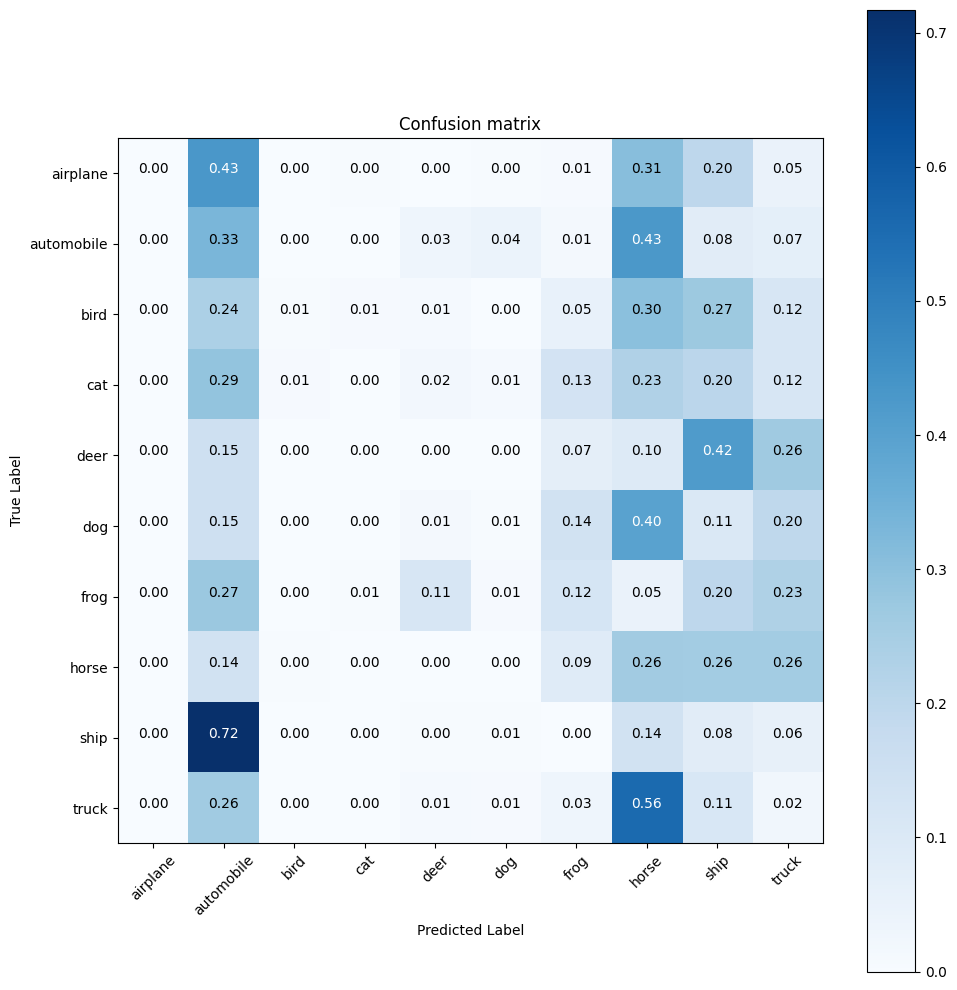

In [21]:
plot_confusion_matrix(y_test, X_test, model_test, classes, title='Confusion matrix')

In [22]:
model_count += 1
# we've been overfitting pretty badly on the last few models, so let's add in some dropout
core_layers = [
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
]

model_train, model_test = ModelBuilder().build(core_layers, name=f"Model_{model_count}")

history = model_train.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data=(X_test, y_test),
)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 150s 95ms/step - loss: 2.1264 - sparse_accuracy: 0.2685 - val_loss: 1.3960 - val_sparse_accuracy: 0.4963
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 163s 105ms/step - loss: 1.4947 - sparse_accuracy: 0.4688 - val_loss: 1.1811 - val_sparse_accuracy: 0.5863
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 160s 102ms/step - loss: 1.2948 - sparse_accuracy: 0.5417 - val_loss: 1.0619 - val_sparse_accuracy: 0.6297
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 151s 97ms/step - loss: 1.1383 - sparse_accuracy: 0.6024 - val_loss: 0.9730 - val_sparse_accuracy: 0.6629
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 151s 97ms/step - loss: 1.0294 - sparse_accuracy: 0.6421 - val_loss: 0.9182 - val_sparse_accuracy: 0.6801
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 151s 96ms/step - loss: 0.9321 - sparse_accuracy: 0.6767 - val_loss: 0.8840 - val_sparse_accuracy: 0.6987
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 166s 106ms/step - loss: 0.8669 - sparse_accuracy: 0.7000 - val_loss: 0.844

In [24]:
model_train.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.7589 - sparse_accuracy: 0.7339


[0.7650837898254395, 0.7357000112533569]

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


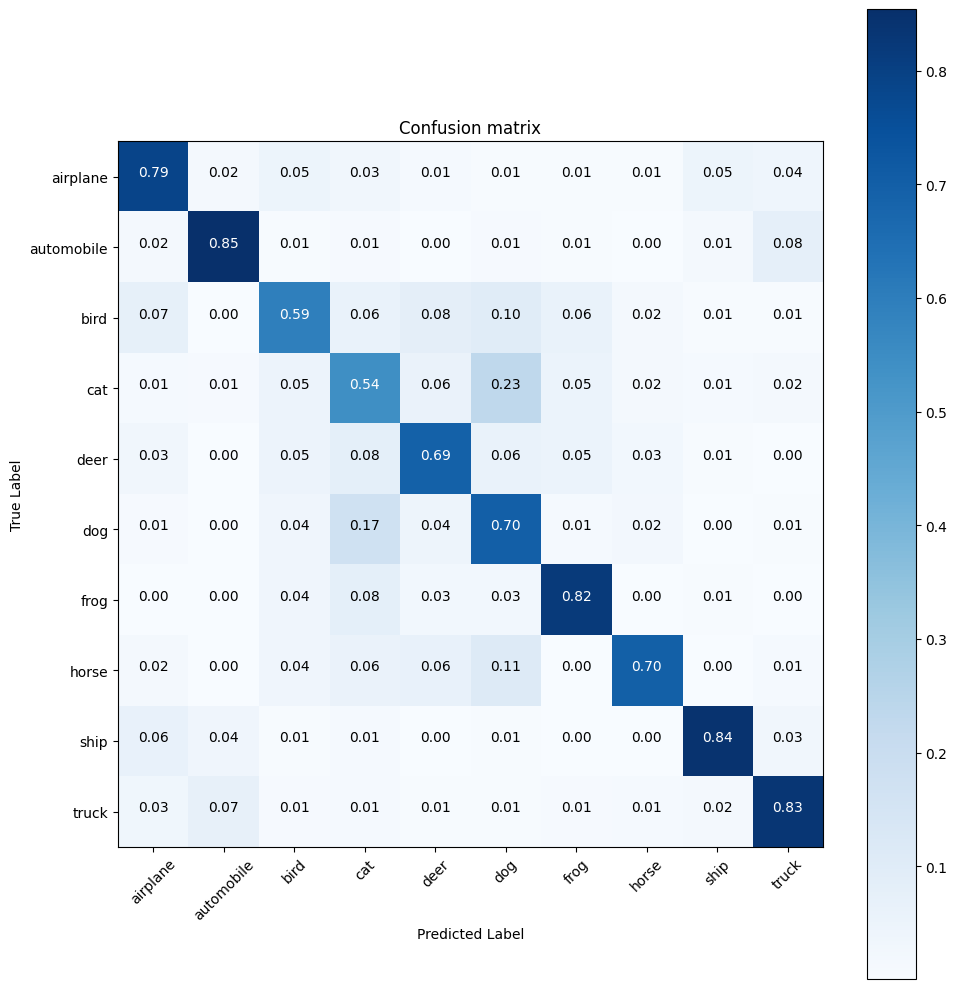

In [25]:
plot_confusion_matrix(y_test, X_test, model_train, classes, title='Confusion matrix')

In [27]:
# that model has definitely worked the best so far with minimal overfitting, so let's increase the epochs
epochs = 30
model_count += 1
# we've been overfitting pretty badly on the last few models, so let's add in some dropout
core_layers = [
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
]

model_train, _ = ModelBuilder().build(core_layers, name=f"Model_{model_count}")

history = model_train.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data=(X_test, y_test),
)

Epoch 1/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 111s 69ms/step - loss: 2.1272 - sparse_accuracy: 0.2761 - val_loss: 1.3303 - val_sparse_accuracy: 0.5282
Epoch 2/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 126s 80ms/step - loss: 1.4823 - sparse_accuracy: 0.4768 - val_loss: 1.1727 - val_sparse_accuracy: 0.5890
Epoch 3/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 75s 48ms/step - loss: 1.2748 - sparse_accuracy: 0.5501 - val_loss: 1.0730 - val_sparse_accuracy: 0.6219
Epoch 4/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 111s 71ms/step - loss: 1.1444 - sparse_accuracy: 0.5993 - val_loss: 1.0199 - val_sparse_accuracy: 0.6528
Epoch 5/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 114s 73ms/step - loss: 1.0448 - sparse_accuracy: 0.6355 - val_loss: 0.9197 - val_sparse_accuracy: 0.6836
Epoch 6/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 98s 63ms/step - loss: 0.9441 - sparse_accuracy: 0.6733 - val_loss: 0.8578 - val_sparse_accuracy: 0.7112
Epoch 7/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 84s 53ms/step - loss: 0.8869 - sparse_accuracy: 0.6899 - val_loss: 0.8327 - va

In [29]:
model_train.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.8956 - sparse_accuracy: 0.7721


[0.9081398248672485, 0.7716000080108643]

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


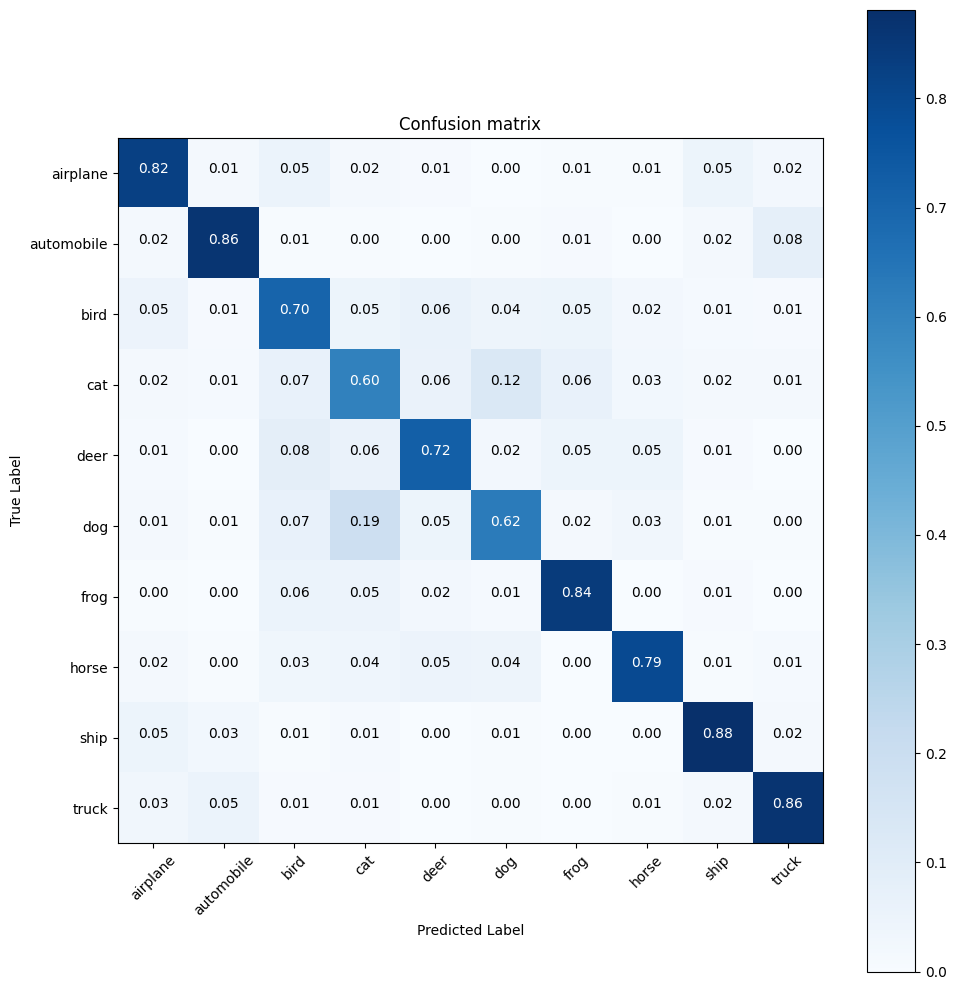

In [28]:
plot_confusion_matrix(y_test, X_test, model_train, classes, title='Confusion matrix')

In [36]:
# we're beginning to see some overfitting, so let's add in some data augmentation
model_count += 1
# we've been overfitting pretty badly on the last few models, so let's add in some dropout
core_layers = [
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
]

model_train, model_test = ModelBuilder().augmentation().build(core_layers, name=f"Model_{model_count}")

# add in early stopping as well
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model_train.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
)

Epoch 1/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 174s 109ms/step - loss: 2.2718 - sparse_accuracy: 0.2208 - val_loss: 1.5737 - val_sparse_accuracy: 0.4308
Epoch 2/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 167s 107ms/step - loss: 1.8046 - sparse_accuracy: 0.3552 - val_loss: 1.4459 - val_sparse_accuracy: 0.4819
Epoch 3/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 155s 99ms/step - loss: 1.6953 - sparse_accuracy: 0.3985 - val_loss: 1.4013 - val_sparse_accuracy: 0.5033
Epoch 4/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 167s 107ms/step - loss: 1.5932 - sparse_accuracy: 0.4334 - val_loss: 1.3733 - val_sparse_accuracy: 0.5076
Epoch 5/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 172s 110ms/step - loss: 1.5300 - sparse_accuracy: 0.4609 - val_loss: 1.2962 - val_sparse_accuracy: 0.5429
Epoch 6/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 167s 107ms/step - loss: 1.4601 - sparse_accuracy: 0.4882 - val_loss: 1.2777 - val_sparse_accuracy: 0.5528
Epoch 7/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 162s 104ms/step - loss: 1.4163 - sparse_accuracy: 0.4994 - val_loss: 1.

In [38]:
model_train.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.8509 - sparse_accuracy: 0.7117


[0.8517665266990662, 0.7128000259399414]

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step


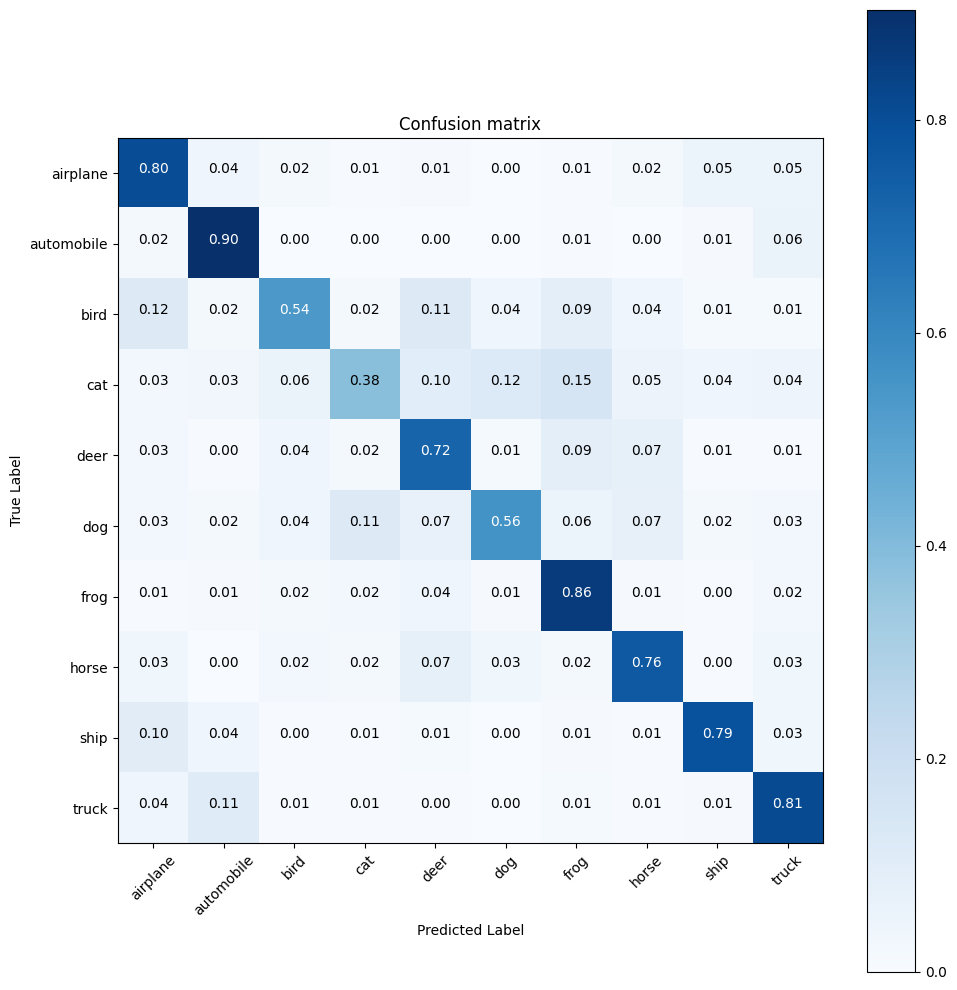

In [39]:
plot_confusion_matrix(y_test, X_test, model_train, classes, title='Confusion matrix')

In [40]:
# it looks like we're no longer overfitting, but our accuracy seems to have plateaued
# let's try adding in some more layers
model_count += 1
# we've been overfitting pretty badly on the last few models, so let's add in some dropout
core_layers = [
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
]

model_train, _ = ModelBuilder().augmentation().build(core_layers, name=f"Model_{model_count}")

# add in early stopping as well
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model_train.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
)

Epoch 1/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 358s 225ms/step - loss: 2.3421 - sparse_accuracy: 0.2027 - val_loss: 1.6283 - val_sparse_accuracy: 0.4115
Epoch 2/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 211s 135ms/step - loss: 1.8369 - sparse_accuracy: 0.3366 - val_loss: 1.4979 - val_sparse_accuracy: 0.4619
Epoch 3/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 208s 133ms/step - loss: 1.7059 - sparse_accuracy: 0.3915 - val_loss: 1.3639 - val_sparse_accuracy: 0.5199
Epoch 4/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 209s 133ms/step - loss: 1.6096 - sparse_accuracy: 0.4284 - val_loss: 1.3621 - val_sparse_accuracy: 0.5126
Epoch 5/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 182s 116ms/step - loss: 1.5108 - sparse_accuracy: 0.4601 - val_loss: 1.2675 - val_sparse_accuracy: 0.5437
Epoch 6/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 234s 150ms/step - loss: 1.4319 - sparse_accuracy: 0.4918 - val_loss: 1.1671 - val_sparse_accuracy: 0.5836
Epoch 7/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 215s 137ms/step - loss: 1.3610 - sparse_accuracy: 0.5188 - val_loss: 1

In [42]:
model_train.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - loss: 0.7189 - sparse_accuracy: 0.7603


[0.7272707223892212, 0.7538999915122986]

313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step


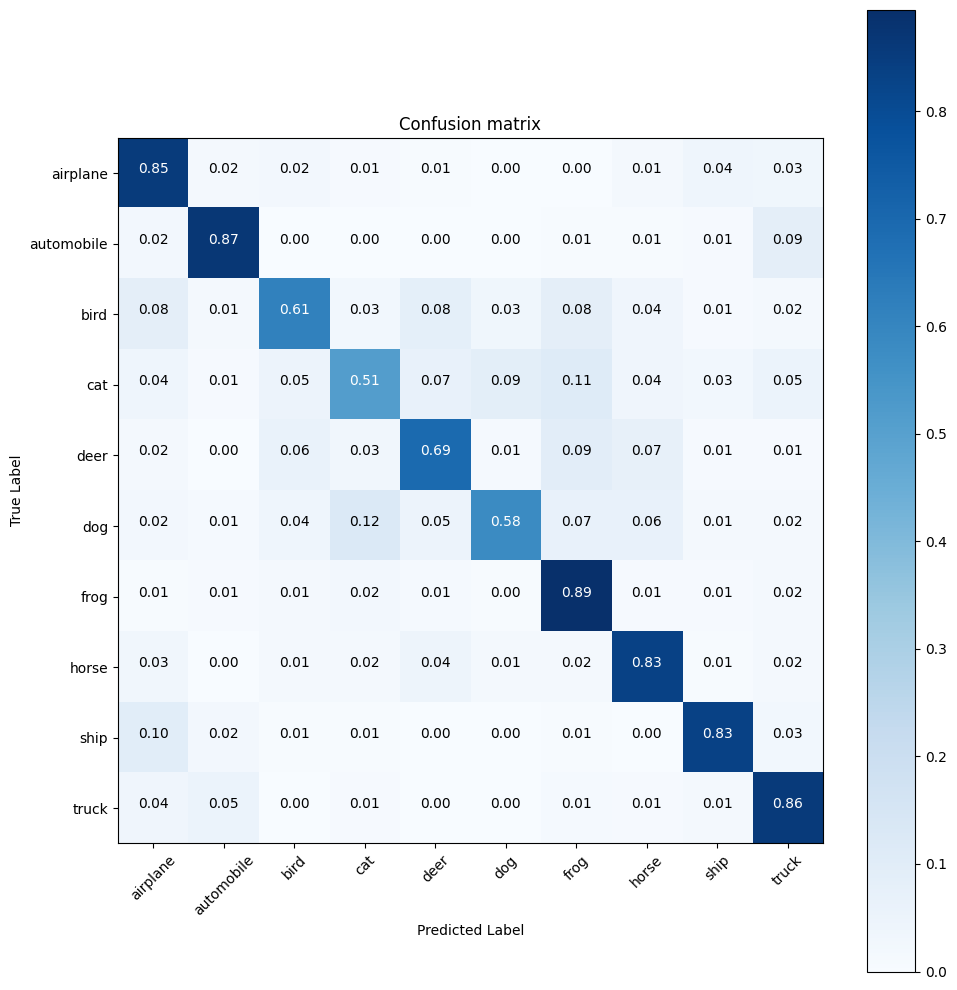

In [44]:
plot_confusion_matrix(y_test, X_test, model_train, classes, title='Confusion matrix')

In [46]:
model_count += 1
epochs = 10
# we got diminishing returns pretty quickly
# let's remove batch normalization layers and decrease dropout
core_layers = [
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
]

model_train, _ = ModelBuilder().augmentation().build(core_layers, name=f"Model_{model_count}")

# add in early stopping as well
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model_train.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 236s 148ms/step - loss: 2.0142 - sparse_accuracy: 0.2551 - val_loss: 1.5811 - val_sparse_accuracy: 0.4295
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 227s 145ms/step - loss: 1.6745 - sparse_accuracy: 0.3971 - val_loss: 1.4756 - val_sparse_accuracy: 0.4677
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 228s 146ms/step - loss: 1.5726 - sparse_accuracy: 0.4340 - val_loss: 1.3800 - val_sparse_accuracy: 0.5020
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 246s 157ms/step - loss: 1.4911 - sparse_accuracy: 0.4690 - val_loss: 1.3148 - val_sparse_accuracy: 0.5282
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 229s 147ms/step - loss: 1.4196 - sparse_accuracy: 0.4934 - val_loss: 1.3833 - val_sparse_accuracy: 0.5063
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 234s 150ms/step - loss: 1.3722 - sparse_accuracy: 0.5111 - val_loss: 1.2140 - val_sparse_accuracy: 0.5674
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 261s 167ms/step - loss: 1.3289 - sparse_accuracy: 0.5243 - val_loss: 1

In [ ]:
model_count += 1
epochs = 10
core_layers = [
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
]

model_train, _ = ModelBuilder().augmentation().build(core_layers, name=f"Model_{model_count}")

# add in early stopping as well
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model_train.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
)

In [ ]:
model_count += 1
epochs = 10
core_layers = [
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
]

model_train, _ = ModelBuilder().augmentation().build(core_layers, name=f"Model_{model_count}")

# add in early stopping as well
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model_train.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
)

## Conclusion

Conclusion

In [ ]:
notebook_end_time = datetime.datetime.now()
print(f"Notebook last run (end-to-end): {notebook_end_time} (duration: {notebook_end_time - notebook_start_time})")